In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd


data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SIT723/fer2013.csv')

pixels = data['pixels']
emotions = data['emotion']
usages = data['Usage']

num_of_instances = len(data) #Get the number of data sets
print("The number of data sets is:",num_of_instances)


In [ ]:
#Tidy up the dataset
from tensorflow.keras.utils import to_categorical

#emotions_Str=['anger','disgust','fear','happy','neutral','sad','surprised']
num_classes = 7   #Number of emoticons
x_train,y_train,x_val,y_val,x_test,y_test = [],[],[],[],[],[]
from tqdm import tqdm
for i in tqdm(range(num_of_instances)):
    #one_hot_label = to_categorical(emotions[i],num_classes) #Tags are converted to one-hot encoding to meet the data requirements of keras
    img = list(map(eval,pixels[i].split(' ')))
    np_img = np.asarray(img)
    img = np_img.reshape(48,48)
    if usages[i] == 'Training':
        x_train.append(img)
        y_train.append(emotions[i])
    elif usages[i] == 'PrivateTest':
        x_val.append(img)
        y_val.append(emotions[i])
    else:
        x_test.append(img)
        y_test.append(emotions[i])

# convert data to array format
x_train = np.array(x_train)
y_train = np.array(y_train)
x_train = x_train.reshape(-1,48,48,1)
x_test = np.array(x_test)
y_test = np.array(y_test)
x_test = x_test.reshape(-1,48,48,1)
x_val = np.array(x_val).reshape(-1,48,48,1)
y_val = np.array(y_val)

#Length and shape of data
print('Length of training, testing, validating are:')
len(x_train),len(x_test),len(x_val)

x_val.shape

100%|██████████| 35887/35887 [04:40<00:00, 128.13it/s]


Length of training, testing, validating are:


(3589, 48, 48, 1)

In [41]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

#Load already prepared CK+
def load_CKplus():
  x = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/inputs.csv",header=None)
  y = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/labels.csv",header=None)
  x, y = shuffle(x, y)
  x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=100, random_state=20)
  x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,test_size=100, random_state=20)
  return x_train, y_train, x_test, y_test, x_val, y_val

#Load already prepared FER2013
def load_FER2013():
  x_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/x_train.csv",header=None)
  y_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/y_train.csv",header=None)
  x_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/x_test.csv",header=None)
  y_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/y_test.csv",header=None)
  x_val = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/x_val.csv",header=None)
  y_val = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/y_val.csv",header=None)
  return x_train, y_train, x_test, y_test, x_val, y_val


x_train, y_train, x_test, y_test, x_val, y_val = load_CKplus() 

x_train = np.array(x_train)
x_train = x_train.reshape(len(x_train),48,48,1)
y_train = np.array(y_train)
x_test = np.array(x_test)
x_test = x_test.reshape(len(x_test),48,48,1)
y_test = np.array(y_test)
x_val = np.array(x_val)
x_val = x_val.reshape(len(x_val),48,48,1)
y_val = np.array(y_val)

# view the shape of dataset
x_train.shape, x_test.shape, x_val.shape


((781, 48, 48, 1), (100, 48, 48, 1), (100, 48, 48, 1))

In [3]:
#face recognition packages
!pip install opencv-python
!pip install face_recognition

     |████████████████████████████████| 100.1 MB 21 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566185 sha256=37604ce49b518b2179f8549b829ccace87ea24e119627143d3d0b5866678d478
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


In [44]:
#face detection, crop, sharpen, emboss using both face_recognition and cv2 packages
import face_recognition
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image, ImageEnhance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

face_cascade_name = cv2.data.haarcascades + 'haarcascade_frontalface_alt.xml'
face_cascade = cv2.CascadeClassifier()
if not face_cascade.load(cv2.samples.findFile(face_cascade_name)):
    print("Error loading xml file")
    exit(0)


def pre_process(input, target):
  count = 0
  x_temp = []
  y_temp = []
  #plt.figure(figsize=[8,8])
  for i in range(len(input)):
    img = np.array(input[i],'uint8')
    face_detect_1 = face_recognition.face_locations(img) #Using face_recoginition
    face_detect_2 = face_cascade.detectMultiScale(img,1.1, 1) #Using cv2
    if (len(face_detect_1)>0):
      (y, w, h, x) = face_detect_1[0]
      img = img[y:y + h, x:x + w]
      img = cv2.resize(img, (48,48))
      img = Image.fromarray(img)
      filter = ImageEnhance.Sharpness(img)
      img = filter.enhance(3.0)
      #filter = ImageEnhance.Contrast(img)
      #img = filter.enhance(3.0)
      img = img.filter(ImageEnhance.ImageFilter.EMBOSS)
      img = np.array(img)
      img = img.reshape(48,48,1)
      x_temp.append(img)
      y_temp.append(target[i])
      count += 1
    else: 
      if (len(face_detect_2)>0):
        (x, y, w, h) = face_detect_2[0]
        img = img[y:y + h, x:x + w]
        img = cv2.resize(img, (48,48))
        img = Image.fromarray(img)
        filter = ImageEnhance.Sharpness(img)
        img = filter.enhance(3.0)
        #filter = ImageEnhance.Contrast(img)
        #img = filter.enhance(3.0)
        img = img.filter(ImageEnhance.ImageFilter.EMBOSS)
        img = np.array(img)
        img = img.reshape(48,48,1)
        x_temp.append(img)
        y_temp.append(target[i])
        count += 1
    #cv2.rectangle(img, (x, y), (x+w, y+h), (0,0,0), 1)
    #print(i, x, y, w, h)
    '''plt.subplot(5,5,1+i)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img, cmap='gray')
    #cv2_imshow(cv2.resize(img, (96,96)))
  plt.show()
  count
  '''
  x_temp = np.array(x_temp)
  y_temp = np.array(y_temp)
  return x_temp, y_temp
  #pd.DataFrame(x_temp.reshape(len(x_temp),2304)).to_csv('x_train.csv',header=None,index=None)
  #pd.DataFrame(y_temp).to_csv('y_train.csv',header=None,index=None)

x_train, y_train = pre_process(x_train, y_train)
x_test, y_test = pre_process(x_test, y_test)
x_val, y_val = pre_process(x_val, y_val)

#For conveniency when training
trainx = x_train.copy()
trainy = y_train.copy()
testx = x_test.copy()
testy = y_test.copy()
valx = x_val.copy()
valy = y_val.copy()


(100, 100, 100, 100)

Display 25 images from the train set in the form of 5x5 matrix with their respective labels:


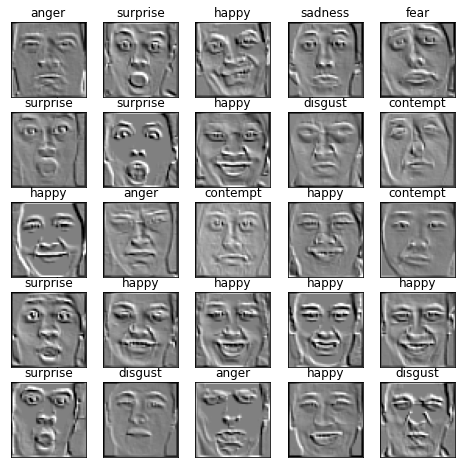

In [46]:
import matplotlib.pyplot as plt
# Displaying 25 images from training dataset in 5x5 matrix
#emotion={0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'} #for FER2013
emotion = {0:'anger',1:'contempt',2:'disgust',3:'fear',4:'happy',5:'sadness',6:'surprise'} #for CK+
print("Display 25 images from the train set in the form of 5x5 matrix with their respective labels:")
plt.figure(figsize=[8,8])
for i in range(25):
  plt.subplot(5,5,1+i)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x_train[i].reshape([48,48]), cmap='gray')
  plt.title(emotion[int(y_train[i])])

plt.show()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_430 (Conv2D)             (None, 48, 48, 16)   160         input_17[0][0]                   
__________________________________________________________________________________________________
batch_normalization_240 (BatchN (None, 48, 48, 16)   64          conv2d_430[0][0]                 
__________________________________________________________________________________________________
activation_406 (Activation)     (None, 48, 48, 16)   0           batch_normalization_240[0][0]    
___________________________________________________________________________________________

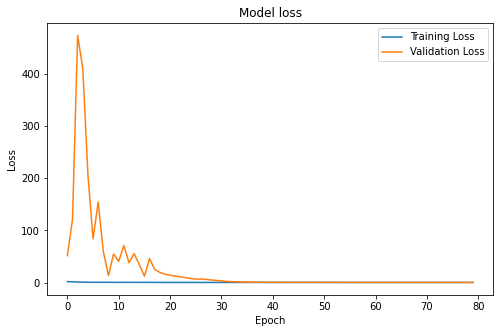

Plot the accuracy (Train and Validation)


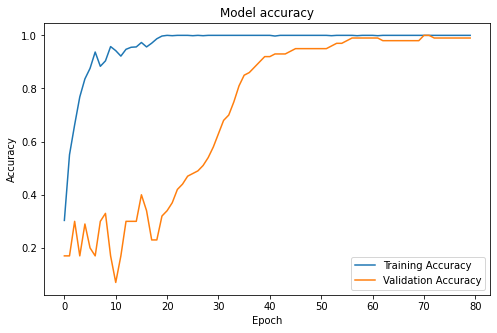

In [50]:
#CBAM

from __future__ import print_function
import keras
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import resnet_v1, mobilenets
import numpy as np
import matplotlib.pyplot as plt
import os

# Training parameters
batch_size = 128
epochs = 80
data_augmentation = False
num_classes = 7
subtract_pixel_mean = False  # Subtracting pixel mean improves accuracy
base_model = 'MobileNet'
# Choose what attention_module to use: cbam_block / se_block / None


# Load the CIFAR10 data.
#(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Load the copy of Dataset
x_train = trainx.copy()
y_train = trainy.copy()
x_test = testx.copy()
y_test = testy.copy()
x_val = valx.copy()
y_val = valy.copy()

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
#x_train = x_train.astype('float32') / 255
#x_test = x_test.astype('float32') / 255
#x_val = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean


# Convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
y_val = to_categorical(y_val, num_classes)


depth = 20 # For ResNet, specify the depth (e.g. ResNet50: depth=50, ResNet101: Depth=101)
model = resnet_v1.resnet_v1(input_shape=input_shape, depth=depth,num_classes=7, attention_module='cbam_block')
#model = mobilenets.MobileNet(input_shape=input_shape, classes=num_classes, attention_module='cbam_block')
#model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=lr_schedule(0)),metrics=['accuracy'])
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(), #SGD(decay=2e-5, momentum=0.9, nesterov=True),
              metrics=['accuracy'])
model.summary()

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)
def lr_schedule(epoch):
    lr = 0.01
    if epoch >= 40:
      lr = 0.0001
    elif epoch >= 20:
      lr=0.001
    print('Learning rate: ', lr)
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)


callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    #history = model.fit(x_train, y_train,batch_size=batch_size, epochs=epochs,validation_data=(x_val, y_val), shuffle=True,callbacks=callbacks)
    history = model.fit(x_train, y_train,batch_size=batch_size, epochs=epochs,validation_data=(x_val, y_val),shuffle=True, callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    #history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
    history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    validation_data=(x_val, y_val),
                    epochs=epochs, verbose=1, workers=4,
                    callbacks=callbacks)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)


def plot_model_history(history):
  # Plot training loss values
  print("Plot loss values (Train vs. Validation)")
  plt.figure(figsize=(8, 5))
  plt.plot(history.history['loss'],label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend()
  plt.show()

  print("Plot the accuracy (Train and Validation)")
  plt.figure(figsize=(8, 5))
  plt.plot(history.history['accuracy'],label='Training Accuracy')
  plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend()
  plt.show()

plot_model_history(history)

In [ ]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy, categorical_crossentropy
from tensorflow.keras.optimizers import Adam, RMSprop
import matplotlib.pyplot as plt

# Model configuration
batch_size = 128
loss_function = categorical_crossentropy
no_classes = 7
no_epochs = 30
optimizer = RMSprop(lr = 0.01)
verbosity = 1


# Load FER2013 Dataset
x_train = trainx.copy()
y_train = trainy.copy()
x_test = testx.copy()
y_test = testy.copy()
x_val = valx.copy()
y_val = valy.copy()


# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
#x_train = x_train.astype('float32') / 255
#x_test = x_test.astype('float32') / 255
#x_val = x_test.astype('float32') / 255


# Convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
y_val = to_categorical(y_val, num_classes)

# Create the model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(512, kernel_size=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(1, 1)))
model.add(Conv2D(1024, kernel_size=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(1, 1)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(no_classes, activation='softmax'))

# Compile the model
model.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=['accuracy'])

# Fit data to model
history = model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=no_epochs,
            validation_data = (x_val,y_val),
            verbose=verbosity)

# Generate generalization metrics
score = model.evaluate(x_test, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

# Visualize history
# Plot history: Loss
plt.plot(history.history['val_loss'])
plt.title('Validation loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

# Plot history: Accuracy
plt.plot(history.history['val_accuracy'])
plt.title('Validation accuracy history')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.show()

In [34]:
import glob
emo_folder = {0:'anger',1:'contempt',2:'disgust',3:'fear',4:'happy',5:'sadness',6:'surprise'}
images = []
x = []
y = []
for i, j in emo_folder.items():
  filelist = glob.glob(j + '/*.png')
  for fname in filelist:
    x.append(np.array(Image.open(fname)))
    y.append(i)
x = np.array(x)
y = np.array(y)

pd.DataFrame(x.reshape(len(x),2304)).to_csv('x_train.csv',header=None,index=None)
pd.DataFrame(y).to_csv('y_train.csv',header=None,index=None)

import matplotlib.pyplot as plt
# Displaying 25 images from training dataset in 5x5 matrix
print("Display 25 images from the train set in the form of 5x5 matrix with their respective labels:")
plt.figure(figsize=[8,8])
for i in range(25):
  plt.subplot(5,5,1+i)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x[i].reshape([48,48]), cmap='gray')
  plt.title(emo_folder[int(y[i])])

plt.show()